# **응급상황 자동 인식 및 응급실 연계 서비스**
# 단계2 : 파인튜닝!

## **0.미션**

### (1) 미션1
단계 2에서는 사전 학습된 한국어 BERT 모델을 다운받아, 파인튜닝을 시도합니다. 이를 위해 먼저 적절한 데이터를 수집해야 합니다.

* 학습 데이터 준비
    * 등급별 50개씩 샘플 데이터를 제공합니다.
    * **응급상황 등급(1~5) 별 최소 100건씩** 데이터를 추가로 수집(제작)하세요.
        * 중증도 카테고리 파일에 있는 키워드 참조
        * 제작시 GPT를 적극 활용해 봅시다.
    * 총 데이터 크기 : 600건
        * 제공데이터 100건(20건씩 5개 등급)
        * 추가 제작 500건(100건씩 5개 등급)

|text|label|
|----|----|
|GPT모델의 출력 형태. 응급상황 내용 | 응급등급(1~5)|



### (2) 미션2
미션1에서 준비한 학습데이터를 활용해서 파인튜닝을 시도합니다.

* 사용할 모델 : **klue/bert-base**
* 성능을 높이기 위해 조정할 만한 점(아래 수치는 가이드)
    - 데이터 양 늘리기
    - 하이퍼 파라미터
        - epoch 수 : 5 ~ 20
        - learning_rate : 1e-5 ~ 1e-2
        - batch_size : 16 ~ 32
        - weight_decay : 0.01 ~ 0.1

## 1.환경준비

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project6 폴더를 만들고,
        * 제공 받은 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 라이브러리 설치 및 로딩

In [ ]:
!pip install datasets

* (필요 시) 설치 후 세션 다시 시작

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import load_dataset, Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

from warnings import filterwarnings
FutureWarning
filterwarnings('ignore')

* 함수 생성
    * evaluate : 모델 생성후, 데이터셋(예 : 검증셋)을 이용해서 모델 성능을 평가하기 위한 용도
    * predict :  하나의 문장을 입력받아, 예측결과를 반환

In [ ]:
# 검증셋 평가 함수
def evaluate(val_ds, model, device, tokenizer):
    # 입력 데이터셋 토크나이징 (attention_mask 포함)
    inputs = tokenizer(val_ds['text'], return_tensors="pt", padding=True,
                       truncation=True, max_length=128
    )
    inputs = {key: value.to(device) for key, value in inputs.items()}  # 입력 텐서를 동일한 디바이스로 이동

    # 모델을 지정된 디바이스로 이동
    model = model.to(device)

    with torch.no_grad():  # 평가 과정에서 기울기 계산 비활성화
        outputs = model(**inputs)  # attention_mask를 포함해 입력

    # 예측 및 확률 계산
    probabilities = outputs.logits.softmax(dim=1)

    # probabilities가 GPU에 있을 경우에만 CPU로 이동
    if probabilities.is_cuda:
        probabilities = probabilities.cpu().detach().numpy()
    else:
        probabilities = probabilities.detach().numpy()

    pred = np.argmax(probabilities, axis=1)

    # GPU 메모리에서 필요 없는 텐서 제거 및 캐시 정리
    del inputs
    torch.cuda.empty_cache()

    return pred, probabilities

In [ ]:
# 데이터 예측 함수
def predict(text, model, tokenizer):
    # 입력 문장 토크나이징
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    #inputs = {key: value for key, value in inputs.items()}  # 각 텐서를 GPU로 이동
    inputs = {key: value.to(device) for key, value in inputs.items()}  # 각 텐서를 GPU로 이동

    # 모델 예측
    with torch.no_grad():
        outputs = model(**inputs)

    # 로짓을 소프트맥스로 변환하여 확률 계산
    logits = outputs.logits
    probabilities = logits.softmax(dim=1)

    # 가장 높은 확률을 가진 클래스 선택
    pred = torch.argmax(probabilities, dim=-1).item()

    return pred, probabilities

### (2) 구글드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/project6_2/'

### (3) 데이터 로딩
* 이전 미션에서 준비한 데이터셋을 로딩합니다.

In [ ]:
#df = pd.read_csv(path+'summary_output.csv')
#df = pd.read_csv(path+'summary_output1.csv')
df = pd.read_csv(path+'summary_output2.csv')

In [ ]:
df

,text,label
0,"{""summary"": ""환자가 호흡곤란으로 숨을 쉬기 어려워하고 피부가 푸르스름하게...",1
1,"{""summary"": ""환자가 얼굴이 창백하고 식은땀을 흘리며 맥박이 거의 잡히지 ...",1
2,"{""summary"": ""의식을 잃고 바닥에 쓰러진 환자가 주변 소리에 반응하지 않고...",1
3,"{""summary"": ""심한 호흡곤란으로 인해 환자가 숨을 쉬지 못하고 곤란한 상태""}",1
4,"{""summary"": ""환자가 심각한 쇼크로 인해 혈압 하락 및 의식 잃을 위험""}",1
...,...,...
595,"{""summary"": ""119 신고, 비응급, 만성, 경증, 요로감염, 증상""}",5
596,"{""summary"": ""상지 외상, 만성 경증 통증을 호소하는 환자가 비응급 상태""}",5
597,"{""summary"": ""환자는 만성 구토/구토 증상과 정상외력징후를 보이며 비응급 ...",5
598,"{""summary"": ""상지 외상으로 인해 만성으로 지속되는 경증 통증을 호소하는 ...",5


* y 분포 확인하기

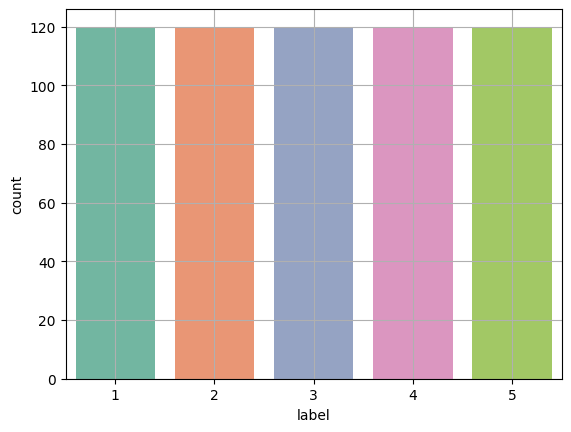

In [ ]:
sns.countplot(x='label', data = df, palette='Set2')
plt.grid()
plt.show()

* label 에 대한 정수 인코딩
    * 정수 인코딩은 0 부터 시작해야 함.

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
df.head()

,text,label
0,"{""summary"": ""환자가 호흡곤란으로 숨을 쉬기 어려워하고 피부가 푸르스름하게...",0
1,"{""summary"": ""환자가 얼굴이 창백하고 식은땀을 흘리며 맥박이 거의 잡히지 ...",0
2,"{""summary"": ""의식을 잃고 바닥에 쓰러진 환자가 주변 소리에 반응하지 않고...",0
3,"{""summary"": ""심한 호흡곤란으로 인해 환자가 숨을 쉬지 못하고 곤란한 상태""}",0
4,"{""summary"": ""환자가 심각한 쇼크로 인해 혈압 하락 및 의식 잃을 위험""}",0


In [ ]:
#df['label: summary']
# 열 이름 변경
df.rename(columns={'text': 'summary'}, inplace=True)

df

,summary,label
0,"{""summary"": ""환자가 호흡곤란으로 숨을 쉬기 어려워하고 피부가 푸르스름하게...",0
1,"{""summary"": ""환자가 얼굴이 창백하고 식은땀을 흘리며 맥박이 거의 잡히지 ...",0
2,"{""summary"": ""의식을 잃고 바닥에 쓰러진 환자가 주변 소리에 반응하지 않고...",0
3,"{""summary"": ""심한 호흡곤란으로 인해 환자가 숨을 쉬지 못하고 곤란한 상태""}",0
4,"{""summary"": ""환자가 심각한 쇼크로 인해 혈압 하락 및 의식 잃을 위험""}",0
...,...,...
595,"{""summary"": ""119 신고, 비응급, 만성, 경증, 요로감염, 증상""}",4
596,"{""summary"": ""상지 외상, 만성 경증 통증을 호소하는 환자가 비응급 상태""}",4
597,"{""summary"": ""환자는 만성 구토/구토 증상과 정상외력징후를 보이며 비응급 ...",4
598,"{""summary"": ""상지 외상으로 인해 만성으로 지속되는 경증 통증을 호소하는 ...",4


In [ ]:
#data = df.drop(columns=['summary', 'label'], inplace=False)
data = df[['summary', 'label']]

In [ ]:
data.rename(columns={'summary': 'text'}, inplace=True)

In [ ]:
data

,text,label
0,"{""summary"": ""환자가 호흡곤란으로 숨을 쉬기 어려워하고 피부가 푸르스름하게...",0
1,"{""summary"": ""환자가 얼굴이 창백하고 식은땀을 흘리며 맥박이 거의 잡히지 ...",0
2,"{""summary"": ""의식을 잃고 바닥에 쓰러진 환자가 주변 소리에 반응하지 않고...",0
3,"{""summary"": ""심한 호흡곤란으로 인해 환자가 숨을 쉬지 못하고 곤란한 상태""}",0
4,"{""summary"": ""환자가 심각한 쇼크로 인해 혈압 하락 및 의식 잃을 위험""}",0
...,...,...
595,"{""summary"": ""119 신고, 비응급, 만성, 경증, 요로감염, 증상""}",4
596,"{""summary"": ""상지 외상, 만성 경증 통증을 호소하는 환자가 비응급 상태""}",4
597,"{""summary"": ""환자는 만성 구토/구토 증상과 정상외력징후를 보이며 비응급 ...",4
598,"{""summary"": ""상지 외상으로 인해 만성으로 지속되는 경증 통증을 호소하는 ...",4


In [ ]:
#data= df

### (4) GPU 설정
* 파이토치를 위한 설정

In [ ]:
# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 2.데이터 준비

### (1) Dataset 만들기 : train, val

In [ ]:
#data = df

In [ ]:
data

,text,label
0,"{""summary"": ""환자가 호흡곤란으로 숨을 쉬기 어려워하고 피부가 푸르스름하게...",0
1,"{""summary"": ""환자가 얼굴이 창백하고 식은땀을 흘리며 맥박이 거의 잡히지 ...",0
2,"{""summary"": ""의식을 잃고 바닥에 쓰러진 환자가 주변 소리에 반응하지 않고...",0
3,"{""summary"": ""심한 호흡곤란으로 인해 환자가 숨을 쉬지 못하고 곤란한 상태""}",0
4,"{""summary"": ""환자가 심각한 쇼크로 인해 혈압 하락 및 의식 잃을 위험""}",0
...,...,...
595,"{""summary"": ""119 신고, 비응급, 만성, 경증, 요로감염, 증상""}",4
596,"{""summary"": ""상지 외상, 만성 경증 통증을 호소하는 환자가 비응급 상태""}",4
597,"{""summary"": ""환자는 만성 구토/구토 증상과 정상외력징후를 보이며 비응급 ...",4
598,"{""summary"": ""상지 외상으로 인해 만성으로 지속되는 경증 통증을 호소하는 ...",4


In [ ]:
## 데이터셋 분할
#train, val = train_test_split(data, test_size=0.2, random_state=42, stratify=data['label'])
train, val = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
train

,text,label
145,"{""summary"": ""중증 호흡곤란 상태 관찰""}",0
9,"{""summary"": ""환자가 경련을 일으키며 몸이 떨리고 혼란스러운 상황""}",0
375,"{""summary"": ""환자가 연기나 물질을 흡입한 후 호흡곤란이 없는 상태로 응급...",2
523,"{""summary"": ""환자가 혹, 돌기, 굳은살 증상을 보이며 비응급 상태로 분류됨""}",4
188,"{""summary"": ""체표면적 25% 이상의 중증 화상을 입은 환자 발생""}",0
...,...,...
71,"{""summary"": ""해를 끼치지 않는 안정된 상태의 환자""}",3
106,"{""summary"": ""환자가 중증 호흡곤란 증상을 보여 위급 상태로 처리됨""}",0
270,"{""summary"": ""급성, 갑작스러운 시력 변화 신고""}",1
435,"{""summary"": ""환자는 손상이 없으며 >= 12시간 동안 경증 증상을 보이며...",3


In [ ]:
val

,text,label
110,"{""summary"": ""환자가 심정지(외상성) 상태로 응급실에 방문했다.""}",0
419,"{""summary"": ""우울증, 자살 생각 없음 상태의 환자 관찰 필요""}",3
565,"{""summary"": ""환자가 쏘임 증상을 보이며 비응급 상태로 분류됨""}",4
77,"{""summary"": ""급성 중심성 경증 통증(<4)을 겪고 있는 환자로, 통증은 ...",3
181,"{""summary"": ""위급 상태의 환자가 심정지(비외상성) 증상을 보이고 있음""}",0
...,...,...
399,"{""summary"": ""전구증상 후 발병 또는 급격한 자세변화시 발병 증상을 가진 ...",2
340,"{""summary"": ""환자가 질출혈로 신고하고 있음""}",2
148,"{""summary"": ""환자가 조절되지 않는 행동으로 응급실 방문""}",0
494,"{""summary"": ""정상 활력, 증상 회복을 요청하는 환자""}",3


In [ ]:
# 텐서 데이터셋으로 변환

train_ds = Dataset.from_pandas(train)
val_ds = Dataset.from_pandas(val)

In [ ]:
train_ds[:3]

{'text': ['{"summary": "중증 호흡곤란 상태 관찰"}',
  '{"summary": "환자가 경련을 일으키며 몸이 떨리고 혼란스러운 상황"}',
  '{"summary": "환자가 연기나 물질을 흡입한 후 호흡곤란이 없는 상태로 응급실을 방문했습니다."}'],
 'label': [0, 0, 2],
 '__index_level_0__': [145, 9, 375]}

### (2) 토큰화

* 사용할 모델("klue/bert-base")의 토크나이저를 저장

In [ ]:
# 모델과 토크나이저 불러오기
# 모델과 토크나이저 불러오기
#model_name = "distilbert-base-uncased"
model_name = "klue/bert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
# 토큰화 함수 생성 및 적용
def preprocess_function(data):
  #return tokenizer(data['summary'], truncation=True, padding=True)
    return tokenizer(data['text'], truncation=True, padding=True)

train_ds = train_ds.map(preprocess_function, batched=True)
val_ds = val_ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/480 [00:00<?, ? examples/s]

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

## 3.Fine-Tuning

### (1) 사전학습 모델 준비
* 사용할 모델("klue/bert-base")의 토크나이저를 저장
* 이때, 출력층 노드 수를 지정합니다.

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# 모델 설정 (다중 분류를 위해 num_labels 지정)
#"klue/bert-base" ?
#n = 6
n = 5
# n = len(unique_labels)
# print(n)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = n).to(device)
#학습에서 에러가 납니다..
#도움이 필요합니다..

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### (2) 학습
* 절차
    * TrainArguments 설정
        * 조정할 하이퍼파라미터 : learning_rate, batch_size, epochs, weight_decay 등
        * 나머지 옵션은 손 대지 맙시다.
    * Trainer 설정
    * 학습
* 성능 : 데이터, 하이퍼파라미터에 의해 결정

In [ ]:
# 학습 하이퍼파라미터 지정
training_args = TrainingArguments(
    output_dir = './results',          # 출력 디렉토리
    eval_strategy = "epoch",            # 에폭마다 평가
    save_strategy = "epoch",           # 에폭마다 체크포인트 저장
    learning_rate = 2e-5,              # <--[조정가능]학습률
    per_device_train_batch_size = 32,  # <--[조정가능]학습 배치 사이즈
    per_device_eval_batch_size = 32,   # <--[조정가능]평가 배치 사이즈
    #num_train_epochs  = 5,              # <--[조정가능]에폭 수
    num_train_epochs  = 50,
    weight_decay = 0.02,               # <--[조정가능]weight decay
    load_best_model_at_end = True,     # 가장 좋은 모델을 마지막에 로드
    logging_dir ='./logs',            # 로깅 디렉토리
    #logging_steps = 10,                # 로깅 스텝
    logging_steps = 1,
    report_to="tensorboard"          # TensorBoard에 로깅
)

In [ ]:
# # TrainingArguments

# lr =                 # <--
# batch_size =         # <--
# epochs =             # <--

# training_args = TrainingArguments(
#     output_dir = './results',          # 출력 디렉토리
#     eval_strategy = "epoch",            # 에폭마다 평가
#     save_strategy = "epoch",           # 에폭마다 체크포인트 저장
#     learning_rate = lr,
#     per_device_train_batch_size = batch_size,
#     per_device_eval_batch_size = batch_size,
#     num_train_epochs  = epochs,
#     weight_decay = 0.02,               # <--[조정가능]weight decay
#     load_best_model_at_end = True,     # 가장 좋은 모델을 마지막에 로드
#     logging_dir ='./logs',            # 로깅 디렉토리
#     logging_steps = 10,                # 로깅 스텝
#     report_to="tensorboard"          # TensorBoard에 로깅
# )

In [ ]:
# Trainer 설정
trainer = Trainer(
    model=model,                         # 학습할 모델
    args=training_args,                  # TrainingArguments
    train_dataset = train_ds,
    eval_dataset = val_ds,
    tokenizer=tokenizer,
    #metric_for_best_model='loss',
    callbacks=[EarlyStoppingCallback(early_stopping_patience=10)], # 조기 종료
)

In [ ]:
# # Trainer 설정
# patience =        # <--

# trainer = Trainer(
#     model=model,                         # 학습할 모델
#     args=training_args,                  # TrainingArguments
#     train_dataset = train_ds,
#     eval_dataset = val_ds,
#     tokenizer=tokenizer,
#     callbacks=[EarlyStoppingCallback(early_stopping_patience=patience)], # 조기 종료
# )

In [ ]:
# 모델 학습

trainer.train()

Epoch,Training Loss,Validation Loss
1,1.550700,1.503328
2,1.141000,1.123676
3,0.783900,0.906033
4,0.716400,0.746034
5,0.518900,0.620523
6,0.324300,0.626163
7,0.342900,0.618923
8,0.165900,0.620483
9,0.062500,0.679425
10,0.027800,0.749858


TrainOutput(global_step=255, training_loss=0.36726352685386787, metrics={'train_runtime': 342.6413, 'train_samples_per_second': 70.044, 'train_steps_per_second': 2.189, 'total_flos': 251606723731200.0, 'train_loss': 0.36726352685386787, 'epoch': 17.0})

In [ ]:
# 모델 평가

eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

Evaluation results: {'eval_loss': 0.6189234852790833, 'eval_runtime': 0.378, 'eval_samples_per_second': 317.493, 'eval_steps_per_second': 10.583, 'epoch': 17.0}


In [ ]:
#text = "I'm absolutely thrilled with the way everything turned out!"
text = '살려줘'
predicted_class, probabilities = predict(text, model, tokenizer)

#key : value.to(device)

print(f"예측된 클래스: {predicted_class}")
print(f"예측된 클래스 이름: {le.inverse_transform([predicted_class])}")
print(f"클래스별 확률: {probabilities}")

예측된 클래스: 0
예측된 클래스 이름: [1]
클래스별 확률: tensor([[0.5193, 0.0880, 0.1759, 0.1405, 0.0763]], device='cuda:0')


### (3) 모델 검증평가
* evaluate 함수를 이용해서 검증셋에 대한 성능 평가를 수행합니다.

In [ ]:
# # 입력 텍스트를 토크나이즈하고 텐서로 변환
# inputs = tokenizer2(text, return_tensors='pt').to(device)  # device는 'cuda' 또는 'cpu'

# # 모델을 동일한 장치로 이동
# model2.to(device)

In [ ]:
tokenizer

BertTokenizerFast(name_or_path='klue/bert-base', vocab_size=32000, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [ ]:
pred, prob = evaluate(val_ds, model, device, tokenizer)
#pred, prob = evaluate(val_ds, model, device, tokenizer, column_name='summary')  # 또는 'summary'

In [ ]:
le.classes_

array([1, 2, 3, 4, 5])

In [ ]:
#val_ds['label']

In [ ]:
#pred, prob = evaluate(train_ds, model, device, tokenizer)

In [ ]:
#pred

array([0, 3, 4, 3, 0, 1, 1, 3, 3, 2, 2, 0, 0, 3, 2, 2, 1, 4, 0, 4, 0, 4,
       4, 4, 4, 3, 1, 0, 4, 4, 4, 0, 4, 3, 0, 3, 0, 4, 3, 1, 2, 1, 4, 4,
       1, 0, 2, 0, 1, 3, 1, 1, 0, 4, 1, 2, 1, 0, 0, 0, 2, 0, 2, 4, 4, 0,
       3, 4, 4, 2, 2, 0, 3, 1, 3, 3, 2, 1, 4, 3, 1, 2, 4, 2, 3, 1, 1, 1,
       2, 1, 1, 3, 3, 2, 2, 1, 1, 3, 3, 4, 4, 1, 4, 2, 3, 3, 2, 1, 1, 3,
       0, 2, 3, 4, 2, 2, 0, 0, 3, 3])

In [ ]:
#print(len(val_ds['label']), len(pred))

120 120


In [ ]:
print(confusion_matrix(val_ds['label'], pred))
print(classification_report(val_ds['label'], pred))# , target_names = le.classes_)
# print(classification_report(train_ds['label'], pred)) # , target_names = le.classes_




[[20  2  1  1  0]
 [ 0 19  2  1  1]
 [ 1  1 15  0  1]
 [ 1  2  4 18  1]
 [ 0  1  0  6 22]]
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        24
           1       0.76      0.83      0.79        23
           2       0.68      0.83      0.75        18
           3       0.69      0.69      0.69        26
           4       0.88      0.76      0.81        29

    accuracy                           0.78       120
   macro avg       0.78      0.79      0.78       120
weighted avg       0.79      0.78      0.79       120



In [ ]:
#print(classification_report(val_ds['label'], pred)) # , target_names = le.classes_)
#[PM 02:54] [상담원] - 네 target_names로 5개의 클래스에 대하여 출력해주신 것으로 보이는데
#[PM 02:55] [상담원] - le.classes_로 넣게 되면 classification_report에서 요구하는 매트릭스 크기랑 다르게 벡터로 값이 들어갑니다

### (4) 모델 사용
* 응급상황에 대한 샘플 문자을 넣고 등급을 적절히 분류하는지 눈으로 확인해 봅시다.

## 4.모델 저장

### (1) 모델 저장
* save_pretrained 메서드를 사용해 모델과 토크나이저를 디렉토리에 저장합니다.
* 저장 대상 : 모델, 토크나이저

In [ ]:
# 모델과 토크나이저 저장 경로 : 폴더가 없으면, fine_tuned_bert를 생성
save_directory = path + "fine_tuned_bert"

# 모델 저장
model.save_pretrained(save_directory)

# 토크나이저도 함께 저장
tokenizer.save_pretrained(save_directory)

('/content/drive/MyDrive/project6_2/fine_tuned_bert/tokenizer_config.json',
 '/content/drive/MyDrive/project6_2/fine_tuned_bert/special_tokens_map.json',
 '/content/drive/MyDrive/project6_2/fine_tuned_bert/vocab.txt',
 '/content/drive/MyDrive/project6_2/fine_tuned_bert/added_tokens.json',
 '/content/drive/MyDrive/project6_2/fine_tuned_bert/tokenizer.json')

### (2) 모델 로딩 및 사용
* 저장한 모델을 나중에 다시 불러와 예측이나 추가 작업에 사용할 수 있습니다. Hugging Face from_pretrained 메서드를 사용하여 저장 경로에서 모델과 토크나이저를 로드합니다.
* 로딩 대상 : 모델, 토크나이저

In [ ]:
# 모델 로드
model2 = AutoModelForSequenceClassification.from_pretrained(save_directory)

# 토크나이저 로드
tokenizer2 = AutoTokenizer.from_pretrained(save_directory)

In [ ]:
# # 입력 텍스트를 토크나이즈하고 텐서로 변환
# inputs = tokenizer2(text, return_tensors='pt').to(device)  # device는 'cuda' 또는 'cpu'

# # 모델을 동일한 장치로 이동
# model2.to(device)

# # 모델 예측
# predicted_class, probabilities = predict(inputs, model2, tokenizer2)

# print(f"예측된 클래스: {predicted_class}")
# print(f"예측된 클래스 이름: {predicted_class + 1}등급")
# print(f"클래스별 확률: {probabilities}")

In [ ]:
# 입력 텍스트를 토크나이즈하고 텐서로 변환
inputs = tokenizer2(text, return_tensors='pt').to(device)  # device는 'cuda' 또는 'cpu'

# 모델을 동일한 장치로 이동
model2.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
text = "넘어졌는데, 지금 출혈이 있고, 머리가 어지럽습니다."
predicted_class, probabilities = predict(text, model2, tokenizer2)
#predicted_class, probabilities = predict(summury, model2, tokenizer2)

print(f"예측된 클래스: {predicted_class}")
print(f"예측된 클래스 이름: {predicted_class+1}등급")
print(f"클래스별 확률: {probabilities}")

예측된 클래스: 0
예측된 클래스 이름: 1등급
클래스별 확률: tensor([[0.3363, 0.3315, 0.1899, 0.0842, 0.0580]], device='cuda:0')


## **Mission Complete!**

수고 많았습니다!